<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

ImportError: No module named watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

UsageError: Line magic function `%watermark` not found.


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time, clock
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [142]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
knn = KNeighborsClassifier(n_neighbors = 100, n_jobs = -1)
#model = knn.fit(X_train, y_train)
train_score = cross_val_score(knn, X_train, y_train, cv = skf, scoring = 'accuracy')
model = knn.fit(X_train, y_train)
preds = knn.predict(X_valid)
ac_score = accuracy_score(y_valid, preds)
#valid_score = cross_val_score(knn, X_valid, y_valid, cv = skf, scoring = 'accuracy')
#''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [17]:
print(train_score.mean())
print(ac_score)

0.564718887006
0.584024650391


In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
forest = RandomForestClassifier(n_estimators  = 100, random_state = 17, oob_score = True, n_jobs = -1)
train_score_forest = cross_val_score(forest, X_train, y_train, cv = skf, scoring = 'accuracy')
model_forest = forest.fit(X_train, y_train)
preds_forest = forest.predict(X_valid)
ac_score_forest = accuracy_score(y_valid, preds_forest)
#''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [31]:
print(model_forest.oob_score_)
print(train_score_forest.mean())
print(ac_score_forest)

0.722515748832
0.712258024957
0.735008295805


In [ ]:
write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',
                     'answer4_2.txt')

In [ ]:
!cat answer4_2.txt

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [11]:
logit = LogisticRegression(random_state = 17)
train_score_logit = cross_val_score(logit, X_train, y_train, cv = skf, scoring = 'accuracy')
model_logit = logit.fit(X_train, y_train)
preds_logit = logit.predict(X_valid)
ac_score_logit = accuracy_score(y_valid, preds_logit)
#''' ВАШ КОД ЗДЕСЬ '''

In [12]:
print(train_score_logit.mean())
print(ac_score_logit)

0.7610267543665875
0.7817018250770325


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [13]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(random_state = 17, multi_class='multinomial', cv = skf, n_jobs=-1, Cs = logit_c_values1)
#''' ВАШ КОД ЗДЕСЬ ''' 
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 23.3 s


In [14]:
logit_c_values1

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

In [15]:
logit_grid_searcher1.scores_[31].mean(axis = 0)

array([0.31822225, 0.47337913, 0.55273512, 0.65119285, 0.71297117,
       0.75137565, 0.75919878, 0.75584868, 0.74965036, 0.73827105])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [16]:
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[31].mean(axis = 0)
#''' ВАШ КОД ЗДЕСЬ '''


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [17]:
print(logit_mean_cv_scores1.max())
print(logit_c_values1[logit_mean_cv_scores1.argmax()])

0.7591987845526015
1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

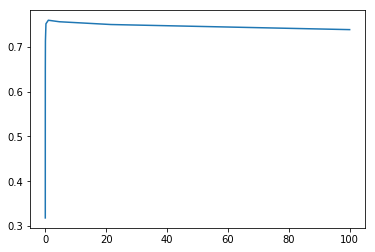

In [18]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [19]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(random_state = 17, multi_class='multinomial', cv = skf, n_jobs=-1, Cs = logit_c_values2)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 55.1 s


In [24]:
logit_c_values2

array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [20]:
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[31].mean(axis = 0)

In [23]:
logit_grid_searcher2.scores_

{31: array([[0.72359209, 0.75372907, 0.75159817, 0.75159817, 0.75098935,
         0.74977169, 0.74946728, 0.74885845, 0.74703196, 0.74581431,
         0.74611872, 0.74550989, 0.74429224, 0.74368341, 0.74216134,
         0.74063927, 0.74033486, 0.74003044, 0.73942161, 0.7391172 ],
        [0.74870387, 0.7694419 , 0.76974687, 0.76822202, 0.76761208,
         0.76883196, 0.76974687, 0.76913693, 0.76913693, 0.7694419 ,
         0.77066179, 0.76913693, 0.76822202, 0.76913693, 0.76791705,
         0.76761208, 0.76761208, 0.76730711, 0.76700213, 0.76669716],
        [0.73398414, 0.75320317, 0.75442343, 0.75320317, 0.75533862,
         0.75503356, 0.75503356, 0.75503356, 0.75503356, 0.75533862,
         0.75442343, 0.75472849, 0.75472849, 0.75411836, 0.75564369,
         0.75564369, 0.75594875, 0.75655888, 0.75655888, 0.75564369]]),
 33: array([[0.72359209, 0.75372907, 0.75159817, 0.75159817, 0.75098935,
         0.74977169, 0.74946728, 0.74885845, 0.74703196, 0.74581431,
         0.74611872, 

In [22]:
logit_mean_cv_scores2

array([0.7354267 , 0.75879138, 0.75858949, 0.75767446, 0.75798001,
       0.75787907, 0.75808257, 0.75767631, 0.75706748, 0.75686494,
       0.75706798, 0.75645844, 0.75574758, 0.75564624, 0.75524069,
       0.75463168, 0.75463189, 0.75463214, 0.75432754, 0.75381935])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [21]:
print(logit_mean_cv_scores2.max())
print(logit_c_values2[logit_mean_cv_scores2.argmax()])

0.7587913824075879
0.4631578947368421


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

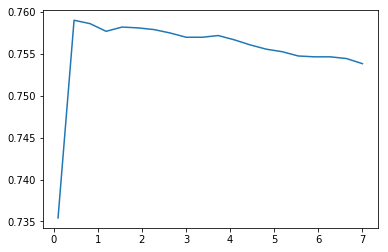

In [61]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [73]:
logit_grid_searcher2

LogisticRegressionCV(Cs=array([ 0.1    ,  0.46316,  0.82632,  1.18947,  1.55263,  1.91579,
        2.27895,  2.64211,  3.00526,  3.36842,  3.73158,  4.09474,
        4.45789,  4.82105,  5.18421,  5.54737,  5.91053,  6.27368,
        6.63684,  7.     ]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=17, refit=True, scoring=None,
           solver='lbfgs', tol=0.0001, verbose=0)

In [62]:
opt_logit = LogisticRegression(random_state = 17, C = 0.463157894737)
train_score_opt_logit = cross_val_score(opt_logit, X_train, y_train, cv = skf, scoring = 'accuracy')
model_opt_logit = opt_logit.fit(X_train, y_train)
preds_opt_logit = opt_logit.predict(X_valid)
logit_cv_acc = accuracy_score(y_valid, preds_opt_logit)

In [34]:
logit_grid_searcher2.Cs

array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [63]:
print(train_score_opt_logit.mean())
print(logit_cv_acc)

0.756251720493
0.772931974402


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [143]:
from sklearn.svm import LinearSVC

In [144]:
svm = LinearSVC(random_state=17, C = 1)
train_score_svm = cross_val_score(svm, X_train, y_train, cv = skf, scoring = 'accuracy')
model_svm = svm.fit(X_train, y_train)
preds_svm = model_svm.predict(X_valid)
ac_score_svm = accuracy_score(y_valid, preds_svm)

In [145]:
print(train_score_svm.mean())
print(ac_score_svm)

0.752797672301
0.776961365252


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [90]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, cv = skf)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 51.8 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [91]:
print(svm_grid_searcher1.best_estimator_)
print(svm_grid_searcher1.best_score_)
#''' ВАШ КОД ЗДЕСЬ '''

LinearSVC(C=3333.3334000000004, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
     tol=0.0001, verbose=0)
0.68451534241


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

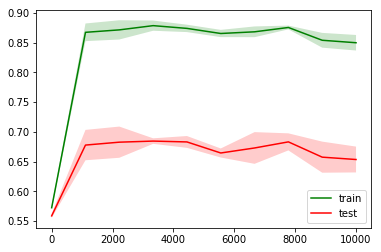

In [92]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [146]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, cv = skf)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 29s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [166]:
print(svm_grid_searcher2.best_estimator_)
print(svm_grid_searcher2.best_score_)
print(svm_grid_searcher2.best_params_['C']) 
#''' ВАШ КОД ЗДЕСЬ '''

LinearSVC(C=0.10434482758620689, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
     tol=0.0001, verbose=0)
0.764681975208
0.104344827586


In [196]:
svm_grid_searcher2.cv_results_

{'mean_fit_time': array([ 0.05466676,  0.18066661,  0.28533332,  0.37300007,  0.45600009,
         0.5583334 ,  0.66166671,  0.72399982,  0.82233326,  0.92133331,
         1.03733325,  1.12793334,  1.15299996,  1.20066682,  1.23300004,
         1.22599983,  1.24366673,  1.2463332 ,  1.24266664,  1.24633312,
         1.23566667,  1.24266664,  1.24333334,  1.25933345,  1.24199994,
         1.24033332,  1.238     ,  1.23499997,  1.23433328,  1.23600006]),
 'mean_score_time': array([ 0.01659997,  0.00100001,  0.0006667 ,  0.00100001,  0.00066662,
         0.00099993,  0.00066662,  0.00066678,  0.00100001,  0.00033331,
         0.00099993,  0.00066662,  0.0006667 ,  0.00066662,  0.00066662,
         0.00100025,  0.00099993,  0.00100001,  0.00100001,  0.00066678,
         0.00100001,  0.00066662,  0.00100017,  0.00099993,  0.00100009,
         0.00099993,  0.0006667 ,  0.00033331,  0.00066678,  0.0006667 ]),
 'mean_test_score': array([ 0.6628734 ,  0.75848405,  0.76254826,  0.76468198,  0.76

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

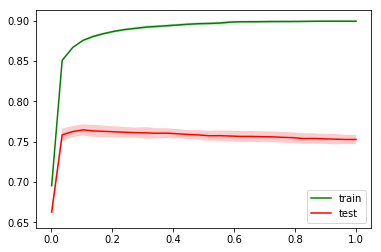

In [148]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [149]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid)) 
#''' ВАШ КОД ЗДЕСЬ '''

In [150]:
svm_cv_acc

0.78075373311211183

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [157]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    start_time = clock()
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    #skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    train_score = cross_val_score(estimator, X_train, y_train, cv = cv, scoring = 'accuracy')
    train_acc = train_score.mean()
    estimator.fit(X_train, y_train)
    svm_cv_acc = accuracy_score(y_valid, estimator.predict(X_valid)) 
    return train_acc, svm_cv_acc, clock() - start_time
    ''' ВАШ КОД ЗДЕСЬ '''

In [158]:
with open('capstone_user_identification/X_sparse_10users_s10_w10.pkl', 'rb') as X_sparse_pkl:
    X_ = pickle.load(X_sparse_pkl)
    print(X_.shape)
with open('capstone_user_identification/X_sparse_10users_s15_w5.pkl', 'rb') as X_sparse_pkl:
    X_ = pickle.load(X_sparse_pkl)
    print(X_.shape)

(14061, 4913)
(28118, 4913)


**Убедитесь, что функция работает.**

In [159]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.76468532445509807, 0.78075373311211183, 1.7908987228147453)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [154]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [160]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = 'X_sparse_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'#''' ВАШ КОД ЗДЕСЬ '''
        path_to_y_pkl = 'y_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
        res = model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, path_to_X_pkl),
        os.path.join(PATH_TO_DATA, path_to_y_pkl), skf, random_state=17, test_size=0.3)
        print('session_length ' + str(session_length) + \
              ' window_szie ' + str(window_size) + \
              ' train score ' + str(res[0]) + ' valid score ' + str(res[1]) + ' time ' + str(res[2]))

session_length 15 window_szie 10 train score 0.823821495528 valid score 0.840483526902 time 3.1153953965986148
session_length 10 window_szie 10 train score 0.764685324455 valid score 0.780753733112 time 1.7178810618934222
session_length 15 window_szie 7 train score 0.847940376984 valid score 0.854322216692 time 4.209970756506664
session_length 10 window_szie 7 train score 0.797016146373 valid score 0.807366849179 time 2.4288543976435903
session_length 7 window_szie 7 train score 0.752989111483 valid score 0.761738841878 time 1.5529830741725164
session_length 15 window_szie 5 train score 0.868001372554 valid score 0.875296348981 time 5.763322020371561
session_length 10 window_szie 5 train score 0.815924720532 valid score 0.824561403509 time 3.421871943108272
session_length 7 window_szie 5 train score 0.774058674563 valid score 0.785324798483 time 2.0715051325241802
session_length 5 window_szie 5 train score 0.72528306504 valid score 0.736249407302 time 1.381779677598388
Wall time: 25.7 

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [161]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = 'X_sparse_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'#''' ВАШ КОД ЗДЕСЬ '''
    path_to_y_pkl = 'y_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
    res = model_assessment(svm_grid_searcher2.best_estimator_, 
        os.path.join(PATH_TO_DATA, path_to_X_pkl),
        os.path.join(PATH_TO_DATA, path_to_y_pkl), skf, random_state=17, test_size=0.3)
    print('session_length ' + str(session_length) + \
              ' window_szie ' + str(window_size) + \
              ' train score ' + str(res[0]) + ' valid score ' + str(res[1]) + ' time ' + str(res[2]))

session_length 5 window_szie 5 train score 0.408586595099 valid score 0.421716065606 time 338.94917891774094
session_length 7 window_szie 7 train score 0.436386494094 valid score 0.452958408557 time 330.4342082221701
session_length 10 window_szie 10 train score 0.461258899943 valid score 0.483627694254 time 268.5356826487114
Wall time: 15min 38s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [25]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [26]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

In [45]:
logit_grid_searcher2.Cs

array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [37]:
%%time
logit_cv_150users = LogisticRegressionCV(multi_class='ovr', random_state=17, cv = skf, Cs = [logit_grid_searcher2.Cs[10]])
#''' ВАШ КОД ЗДЕСЬ '''
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 16min 42s


In [38]:
logit_cv_150users.scores_

{6: array([[0.99619036],
        [0.99630858],
        [0.99573975]]), 13: array([[0.99637772],
        [0.99633986],
        [0.99646023]]), 15: array([[0.99534724],
        [0.99521366],
        [0.99523854]]), 16: array([[0.99203722],
        [0.99236689],
        [0.99144817]]), 28: array([[0.99010117],
        [0.98998936],
        [0.99044576]]), 31: array([[0.99434799],
        [0.9942126 ],
        [0.99433011]]), 33: array([[0.99362978],
        [0.99368079],
        [0.99364095]]), 39: array([[0.9861354 ],
        [0.98545329],
        [0.98599756]]), 46: array([[0.99806395],
        [0.99759119],
        [0.99830843]]), 49: array([[0.99500375],
        [0.99511981],
        [0.99570842]]), 50: array([[0.99416063],
        [0.9949634 ],
        [0.99426746]]), 53: array([[0.993661  ],
        [0.99361822],
        [0.99351565]]), 65: array([[0.99690857],
        [0.99659013],
        [0.99705541]]), 66: array([[0.99487884],
        [0.99474442],
        [0.99467469]]), 82: ar

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [39]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {0}, CV score: {1}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 515, CV score: 0.994025830272
User 2902, CV score: 0.997049421691
User 6, CV score: 0.996079561289
User 13, CV score: 0.996392603416
User 15, CV score: 0.995266482277
User 16, CV score: 0.991950761356
User 533, CV score: 0.993786030831
User 28, CV score: 0.990178765976
User 1054, CV score: 0.996569841221
User 31, CV score: 0.994296898905
User 33, CV score: 0.993650504011
User 1371, CV score: 0.993410398974
User 39, CV score: 0.985862083066
User 46, CV score: 0.997987857445
User 49, CV score: 0.995277328462
User 50, CV score: 0.994463828068
User 563, CV score: 0.996726139256
User 564, CV score: 0.995662909076
User 53, CV score: 0.99359829021
User 568, CV score: 0.991617658001
User 569, CV score: 0.98944907695
User 570, CV score: 0.998342456524
User 573, CV score: 0.990491230318
User 575, CV score: 0.990522870971
User 576, CV score: 0.99405706748
User 65, CV score: 0.996851370058
User 66, CV score: 0.994765980925
User 580, CV score: 0.986612731695
User 2118, CV score: 0.997779407107

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [40]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}

for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = logit_cv_150users.scores_[user_id].mean() - (1 - class_distr[user_id] / len(y_train_150))

In [41]:
#list(filter(lambda x: x > 2000, class_distr))
len(class_distr)

2903

In [42]:
len(acc_diff_vs_constant)

150

In [43]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
print(num_better_than_default)

123


**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [44]:
num_better_than_default / len(logit_cv_150users.scores_)
#''' ВАШ КОД ЗДЕСЬ '''

0.82

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.